In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import matplotlib

import cv2

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from PIL import Image

from skimage.morphology import skeletonize, thin
from skimage.util import invert
from skimage import measure
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage import feature
from skimage.filters import roberts, sobel, scharr, prewitt
import seaborn as sns
sns.reset_orig()

from skimage import restoration

from skimage import exposure
from skimage.filters import gaussian

from scipy import ndimage

from time import time

from skimage.color import rgb2gray

from skimage.color import rgb2hsv
from skimage.color import hsv2rgb



from skimage.filters.rank import entropy
import scipy

from skimage import data, filters
import scipy

import networkx as nx
from scipy import interpolate

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import glob

from skimage.morphology import disk
from skimage import io

from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

/Users/spencerlab/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [2]:
parade = np.asarray(Image.open('RGBParadeImagesSpencerLab/RedChannelParadeRGBSequence1103.tif'))


mask= np.logical_and((parade[:,:,1]==parade[:,:,0]), (parade[:,:,2]==parade[:,:,0]))
parade2 = parade.copy()

mask=mask==0
parade2[:,:,0] = mask*parade[:,:,0]
parade2[:,:,1] = mask*parade[:,:,1]
parade2[:,:,2] = mask*parade[:,:,2]
parade2[:,:,3] = mask*parade[:,:,3]

In [3]:
stack = io.imread("X1Y7.tif")

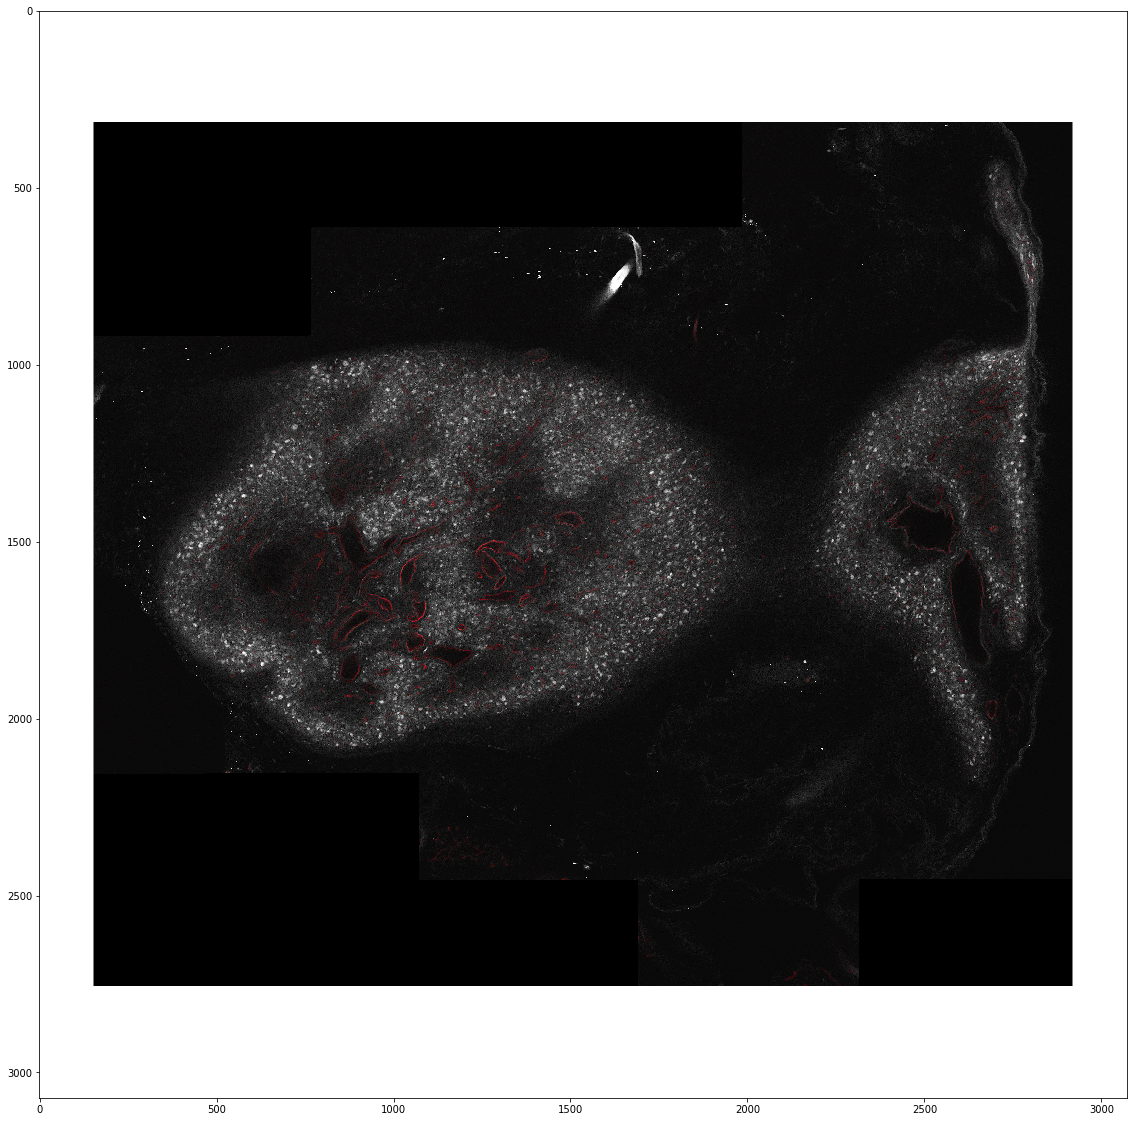

In [4]:
plt.figure(figsize=(20,20))
plt.imshow(parade)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


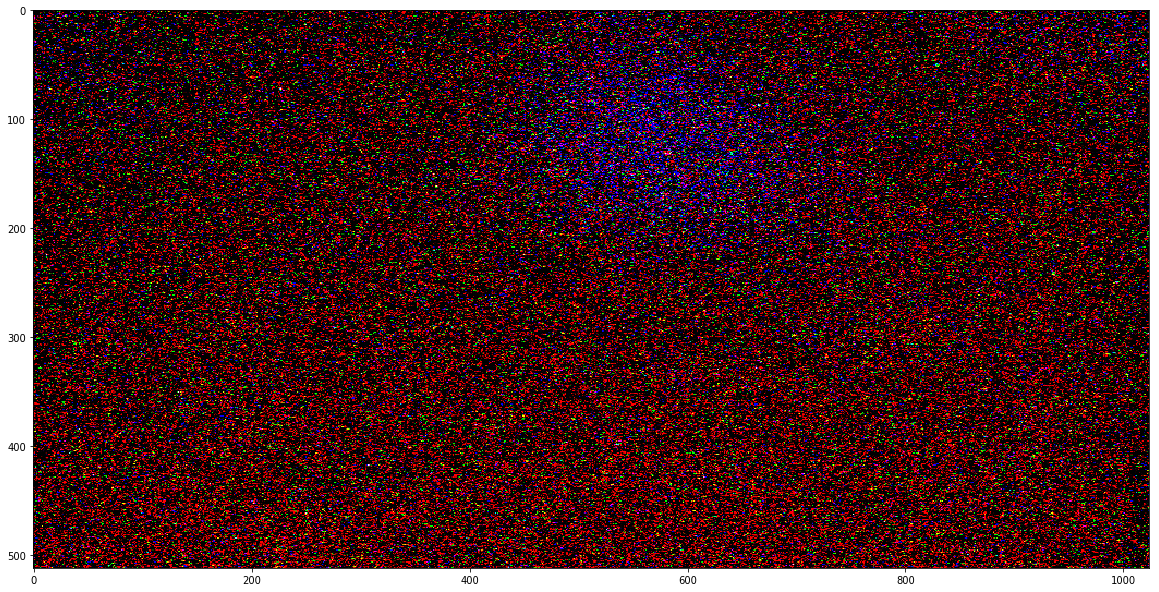

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(stack[150])

In [6]:
def hsv_constraints(image):
    
    hsv_img = rgb2hsv(image)
    
    r_flat = (image[:,:,0]).flatten()
    g_flat = (image[:,:,1]).flatten()
    b_flat = (image[:,:,2]).flatten()



    h_flat = (hsv_img[:,:,0]).flatten()
    s_flat = (hsv_img[:,:,1]).flatten()
    v_flat = (hsv_img[:,:,2]).flatten()
    
    
    
    h_flat_2 = []
    s_flat_2 = []
    v_flat_2 = []
    
    
    for i in range(len(r_flat)):
        if r_flat[i]!=0 or g_flat[i]!=0 or b_flat[i]!=0:
            h_flat_2.append(h_flat[i])
            s_flat_2.append(s_flat[i])
            v_flat_2.append(v_flat[i])
    
    
    h_flat_2 = np.asarray(h_flat_2)

    
    h_unk = np.unique(h_flat_2)
    min_hue = h_unk[0]
    max_hue = h_unk[-1]


    diff = max_hue-min_hue
    
    
    
    
    
    
    
    neg = (h_flat_2-1)*(h_flat_2>=0.5)
    pos = h_flat_2*(h_flat_2<0.5)
    rang = neg+pos
    unk_rang = np.unique(rang)
    
    min_hue_2 = unk_rang[0]
    max_hue_2 = unk_rang[-1]
    
    
    if diff> max_hue_2-min_hue_2:
        min_hue = min_hue_2
        max_hue = max_hue_2
    
    
    
    
    
    
    
    
    unk_Sat = np.unique(s_flat_2)
    unk_Val = np.unique(v_flat_2)
    
    
    min_sat = unk_Sat[0]
    max_sat = unk_Sat[-1]
    
    min_val = unk_Val[0]
    max_val = unk_Val[-1]
    
    return min_hue, max_hue, min_sat, max_sat, min_val, max_val

In [7]:
def keep_inrange(hsv_img, min_h, max_h):
    
    
    neg = (hsv_img[:,:,0]-1)*(hsv_img[:,:,0]>=0.5)
    #neg=neg*(neg>=min_h)
    
    
    pos = hsv_img[:,:,0]*(hsv_img[:,:,0]<0.5)
    #pos = pos*(pos<=max_h)
    
    
    #ret = neg+pos
    
    ret_hsv = hsv_img.copy()
    
    ret_hsv[:,:,1] = hsv_img[:,:,1]*(neg>=min_h)*(pos<=max_h)
    
    return ret_hsv

In [8]:
def clean(inpt):
    ret = inpt.copy()
    for i in range(len(inpt)):
        for x in range(len(inpt[0])):
            if np.isnan(inpt[i,x]):
                ret[i,x]=0
            else:
                ret[i,x]=inpt[i,x]
        
    return ret

In [9]:
def denoise_repeat(image_stk, patch_size, patch_distance, h, n):
    ret = image_stk
    for i in range(n):
        ret=restoration.denoise_nl_means(ret, patch_size=patch_size, patch_distance=patch_distance, h=h)
        ret=clean(ret)
    return ret

In [10]:
def mix_filters(image, patch_size, patch_distance, h, n, canny_sigma, denoise_tresh):
    nlm = denoise_repeat(image[:,:,0], patch_size, patch_distance, h, n)
    
    edges = feature.canny(image[:,:,0], canny_sigma)
    
    
    mix_tresh = np.logical_or(edges,(nlm>denoise_tresh))
    
    return mix_tresh

In [11]:
def remove_specs(inpt, max_spec_size):
    ret = np.ones(inpt.shape)
    for i in range(len(inpt)):
        for x in range(len(inpt[0])):
            num = 0
            for n1 in range(-1,2):
                for n2 in range(-1,2):
                    try:
                        if inpt[i+n1, x+n2] ==1:
                            num=num+1
                    except:
                        cat = 0
            if num <=max_spec_size:
                ret[i, x] = 0
            else:
                ret[i, x] = inpt[i, x]
            
    return ret

In [12]:
mih, mah, mis, mas, miv, mav = hsv_constraints(parade2[:,:,:3])

/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


In [13]:
[mih, mah, mis, mas, miv, mav]

[-0.06439393939393945,
 0.06047197640117993,
 0.004854368932038817,
 1.0,
 0.00784313725490196,
 1.0]

In [14]:
mis = 0.4
mih = -0.03

In [15]:
def color_leave_filter(image, min_hue, max_hue, min_sat, max_sat, min_val, max_val):
    
    hsv_img = rgb2hsv(image) 
    
    kir = keep_inrange(hsv_img, min_hue, max_hue)
    
    kir2=kir.copy()
    kir2[:,:,1]=kir2[:,:,1]
    kir2[:,:,2]=kir2[:,:,2]*(kir2[:,:,1]>=min_sat)*(kir2[:,:,1]<=max_sat)*(kir2[:,:,2]>=min_val)*(kir2[:,:,2]<=max_val)
    

    return (np.round(hsv2rgb(kir2)*255).astype('uint8'))

In [16]:
output_image = color_leave_filter(stack[150], mih, mah, mis, mas, miv, mav)

/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


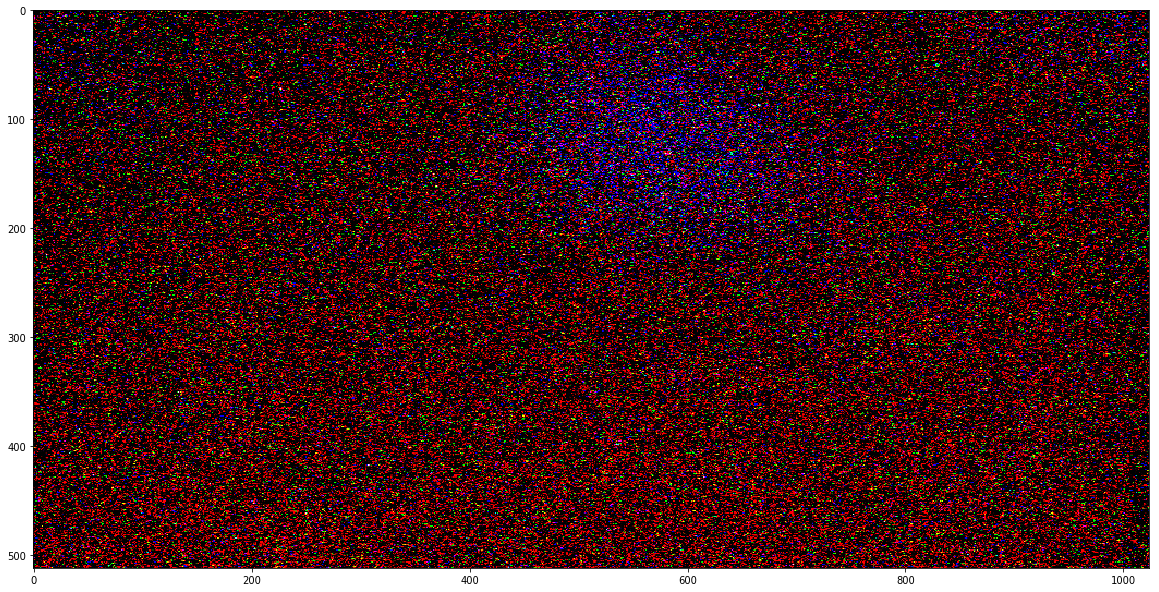

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(stack[150])

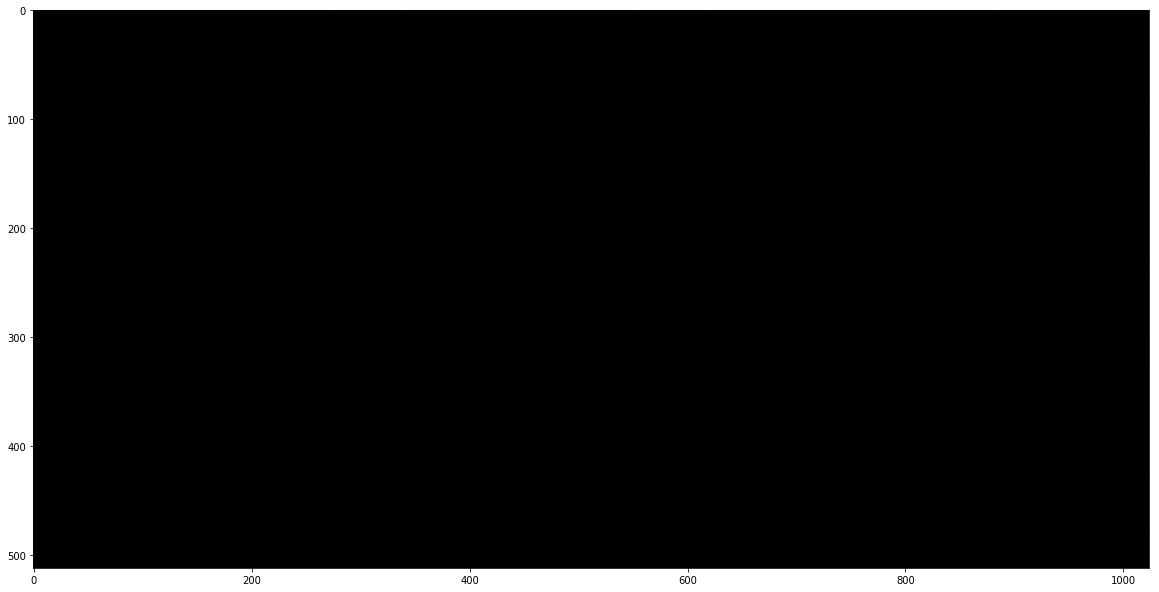

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(output_image)

In [19]:
Image.fromarray(output_image).save('Dayx_parade.tif')

In [20]:
mfilt = mix_filters(image=output_image, patch_size=450, patch_distance=9, h=0.1, n=2, canny_sigma=2, denoise_tresh=50)



/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


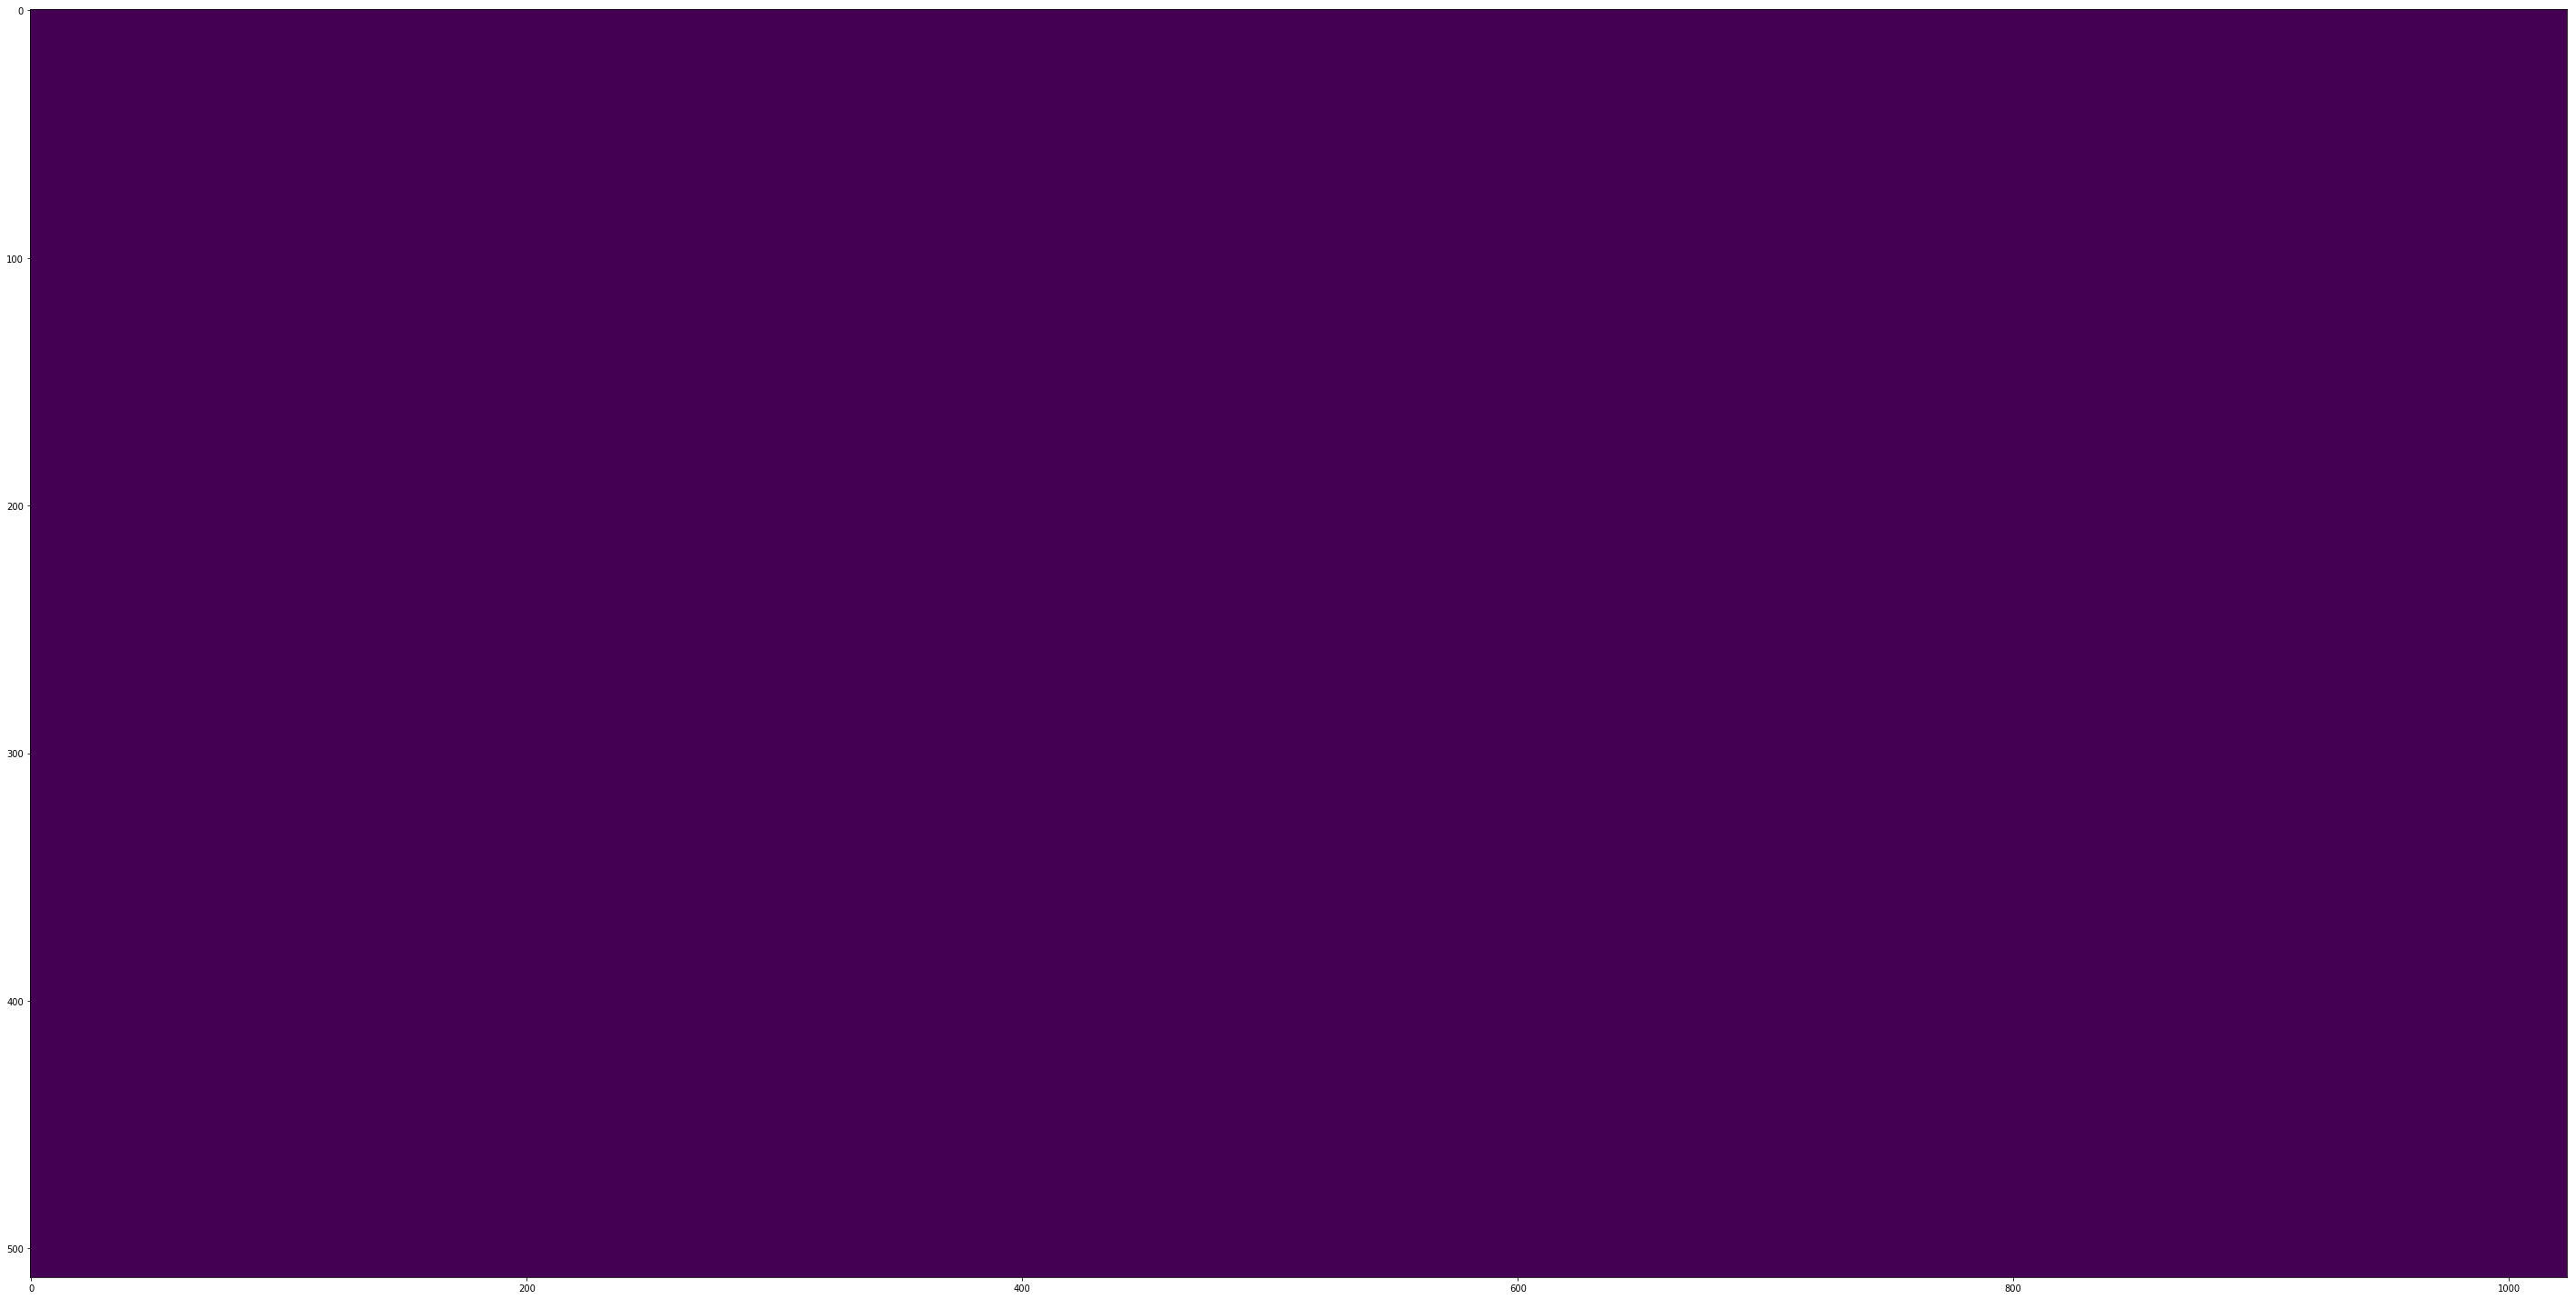

In [21]:
plt.figure(figsize=(50,50))
plt.imshow(mfilt)

In [22]:
square = mfilt!=0

eroded_square = ndimage.binary_erosion(square)
reconstruction = ndimage.binary_propagation(eroded_square, mask=square)
reconstruction2 = ndimage.binary_closing(reconstruction)
Image.fromarray(((reconstruction2!=0)*255).astype('uint8')).save('Day3_parade_bin.tif')

In [23]:
Image.fromarray(((mfilt!=0)*255).astype('uint8')).save('Day3_parade_bin.tif')

In [24]:
for i in range(0, len(stack)):
    clv = color_leave_filter(stack[i], mih, mah, mis, mas, miv, mav)
    mfilt = mix_filters(image=clv, patch_size=450, patch_distance=9, h=0.1, n=2, canny_sigma=2, denoise_tresh=50)

    square = mfilt!=0
    
    eroded_square = ndimage.binary_erosion(square)
    reconstruction = ndimage.binary_propagation(eroded_square, mask=square)
    reconstruction2 = ndimage.binary_closing(reconstruction)
    
    print(i)
    
    Image.fromarray(((reconstruction2!=0)*255).astype('uint8')).save('green2/'+str(i)+'.tif')

/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


0


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


1


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


2


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


3


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


4


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


5


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


6


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


7


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


8


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


9


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


10


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


11


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


12


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


13


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


14


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


15


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


16


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


17


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


18


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


19


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


20


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


21


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


22


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


23


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


24


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


25


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


26


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


27


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


28


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


29


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


30


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


31


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


32


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


33


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


34


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


35


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


36


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


37


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


38


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


39


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


40


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


41


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


42


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


43


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


44


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


45


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


46


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


47


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


48


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


49


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


50


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


51


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


52


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


53


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


54


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


55


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


56


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


57


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


58


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


59


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


60


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


61


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


62


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


63


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


64


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


65


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


66


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


67


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


68


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


69


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


70


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


71


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


72


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


73


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


74


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


75


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


76


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


77


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


78


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


79


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


80


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


81


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


82


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


83


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


84


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


85


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


86


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


87


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


88


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


89


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


90


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


91


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


92


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


93


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


94


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


95


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


96


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


97


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


98


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


99


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


100


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


101


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


102


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


103


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


104


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


105


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


106


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


107


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


108


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


109


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


110


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


111


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


112


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


113


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


114


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


115


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


116


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


117


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


118


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


119


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


120


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


121


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


122


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


123


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


124


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


125


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


126


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


127


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


128


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


129


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


130


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


131


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


132


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


133


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


134


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


135


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


136


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


137


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


138


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


139


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


140


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


141


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


142


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


143


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


144


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


145


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


146


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


147


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


148


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


149


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


150


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


151


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


152


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


153


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


154


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


155


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


156


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


157


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


158


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


159


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


160


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


161


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


162


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


163


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


164


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


165


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


166


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


167


In [25]:
plt.figure(figsize=(20,20))
plt.imshow(closed)

NameError: name 'closed' is not defined

<Figure size 1440x1440 with 0 Axes>

In [ ]:
np.unique(closed*255)

In [ ]:
Image.fromarray( (closed*255).astype('uint8') ).save('3_D_Vessel_seg/'+str(150)+'.tif')

In [ ]:
for i in range(236, 260):
    print(i)
    
    output_image = color_leave_filter(stack[i], mih, mah, mis, mas, miv, mav)
    
    mfilt = mix_filters(image=output_image, patch_size=450, patch_distance=9, h=0.1, n=2, canny_sigma=2, denoise_tresh=50)

    mfilt_DN = remove_specs(mfilt, 2)
    
    closed= scipy.ndimage.binary_closing(mfilt_DN)
    
    Image.fromarray( (closed*255).astype('uint8') ).save('3_D_Vessel_seg/'+str(i)+'.tif')